In [1]:
!pip install seaborn

# Monte Carlo Simulation of Trading Strategies

This project simulates stock price paths using Geometric Brownian Motion and evaluates the performance of several trading strategies:
- Buy & Hold
- Trailing Stop Loss
- Moving Average Crossover
- Bollinger Band Mean Reversion

We analyze each strategy’s profit distribution and risk profile under varying levels of market volThe goal is to analyze which strategy performs best under market uncertainty — a core idea in quantitative finance used by firms.atility.
.


In [3]:
#importing required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Simulating Price Paths using Geometric Brownian Motion (GBM)

We simulate the evolution of asset prices using the Geometric Browninan Motion (GBM) mode, which assumes that returns are normally distributed and that prices evelove with some drift and volatility.

In [5]:
def generate_price_paths (S0, mu, sigma, T, dt, n_paths):
    N = int(T / dt)
    t = np.linspace(0, T, N)
    paths = np.zeros((n_paths, N))
    paths[:,0] = S0
    for i in range (1, N):
        z = np.random.standard_normal(n_paths)
        paths[:,i] = paths[:,i-1]*np.exp((mu - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*z)
    return t, paths

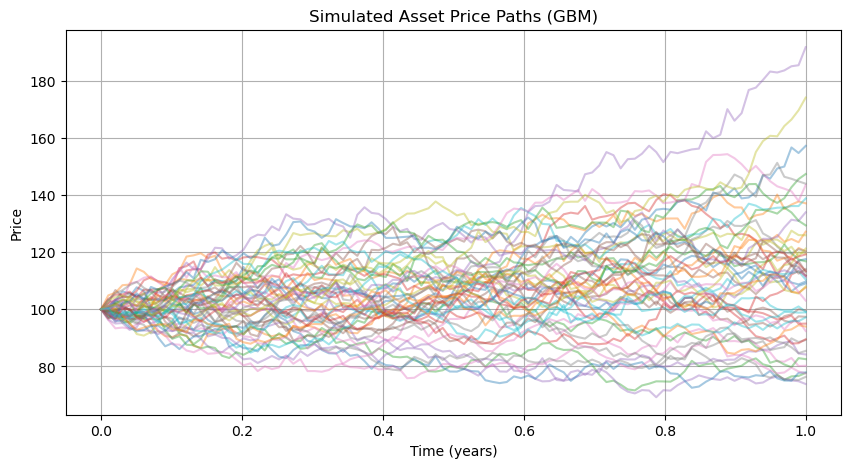

In [6]:
# Code to visualise paths
S0 = 100     # Initial price
mu = 0.05    # Drift (expected return)
sigma = 0.2  # Volatility
T = 1        # Time in years
dt = 0.01    # Time step
n_paths = 50 # number of paths

t, paths = generate_price_paths(S0, mu, sigma, T, dt, n_paths)

# Plotting the obtained results
plt.figure(figsize=(10,5))
plt.plot(t, paths.T, alpha = 0.4)
plt.title("Simulated Asset Price Paths (GBM)")
plt.xlabel("Time (years)")
plt.ylabel("Price")
plt.grid(True)
plt.show()

## Trading Strategies

Each strategy is implemented as a function. These are rule-bad.se We are implementing 4 different strategies:s.

- Buy & Hold: Hold the asset for the full time.
- Trailing Stop: Sell if price falls 10% below peak.
- Moving Average Crossover: Trade based on short- and long-term trend crossovers.
- Bollinger Band Reversion: Buy low, sell at mean, based on band s.
eak.


In [8]:
# Code for defining the strategies
def strategy_hold(prices):
    return prices[-1] - prices[0]

def strategy_trailing_stop(prices, stop_pct=0.05):
    peak = prices[0]
    for price in prices:
        peak = max(peak, price)
        if price <peak*(1-stop_pct):
            return price - prices[0]
    return prices[-1] - prices[0]

In [9]:
def strategy_ma_crossover(prices, short_window=5, long_window=20):
    prices = np.array(prices)

    if len(prices) < long_window:
        return 0  # not enough data

    short_ma = np.convolve(prices, np.ones(short_window)/short_window, mode='valid')
    long_ma = np.convolve(prices, np.ones(long_window)/long_window, mode='valid')

    # Align lengths
    if len(short_ma) < len(long_ma):
        diff = len(long_ma) - len(short_ma)
        short_ma = np.pad(short_ma, (diff, 0), 'constant', constant_values=np.nan)
    else:
        diff = len(short_ma) - len(long_ma)
        long_ma = np.pad(long_ma, (diff, 0), 'constant', constant_values=np.nan)

    # Generate positions
    position = np.where(short_ma > long_ma, 1, 0)
    position = np.pad(position, (len(prices) - len(position), 0), 'constant', constant_values=0)

    # Calculate returns
    returns = np.diff(prices) / prices[:-1]
    pnl = np.sum(returns * position[:-1]) * prices[0]
    return pnl


In [10]:
def strategy_bollinger(prices, window=20, num_std=2):
    prices = np.array(prices)
    if len(prices) < window:
        return 0.0

    rolling_mean = np.convolve(prices, np.ones(window)/window, mode='valid')
    rolling_std = [np.std(prices[i-window+1:i+1]) if i >= window else 0 for i in range(len(prices))]
    rolling_std = np.array(rolling_std[window-1:])  # align with mean

    lower_band = rolling_mean - num_std * rolling_std
    upper_band = rolling_mean + num_std * rolling_std

    signal = 0
    profit = 0
    entry_price = None

    for i in range(len(lower_band)):
        price = prices[i + window - 1]

        if signal == 0 and price < lower_band[i]:
            entry_price = price
            signal = 1  # bought

        elif signal == 1 and price > rolling_mean[i]:
            profit += price - entry_price
            signal = 0  # sold

    return profit


In [11]:
# Comparing all 4 strategies:
n_trials = 1000
strats = ["hold", "stop", "ma", "boll"]
results_all = {strat: [] for strat in strats}

for _ in range(n_trials):
    _, path = generate_price_paths(S0, mu, sigma, T, dt, 1)
    prices = path[0]

    results_all["hold"].append(strategy_hold(prices))
    results_all["stop"].append(strategy_trailing_stop(prices))
    results_all["ma"].append(strategy_ma_crossover(prices))
    results_all["boll"].append(strategy_bollinger(prices))


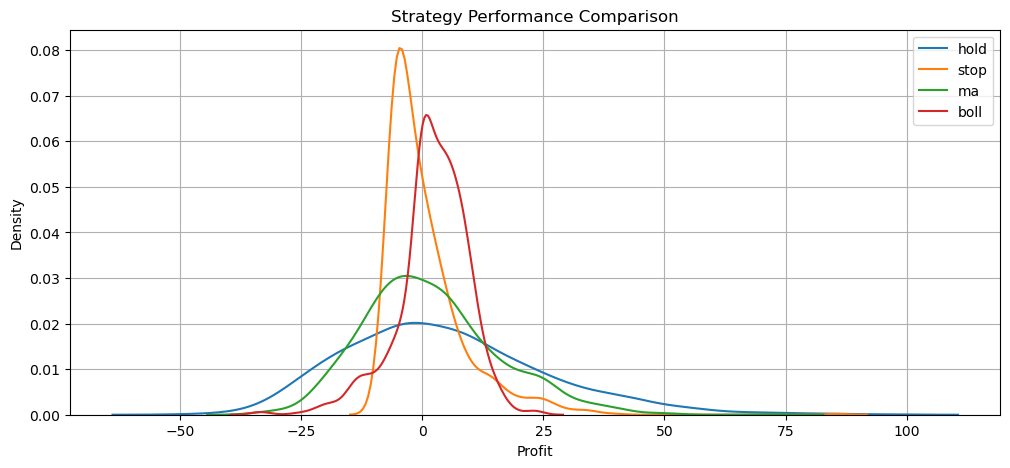

In [12]:
plt.figure(figsize=(12, 5))
for strat in strats:
    sns.kdeplot(results_all[strat], label=strat)
plt.title("Strategy Performance Comparison")
plt.xlabel("Profit")
plt.ylabel("Density")
plt.grid(True)
plt.legend()
plt.show()


## Analysing Performance Metrics

Here we will analyse the performance of the two strategies using the mean and standard deviation of the returns in each path to compare and conclude on which trading strategy is better for our dataset.

In [14]:
def sharpe_ratio (returns, risk_free=0.0):
    return (np.mean(returns) - risk_free) / np.std(returns)


print("Strategy       | Avg Profit | Sharpe Ratio")
print("---------------|------------|--------------")
for strat in strats:
    avg = np.mean(results_all[strat])
    sr = sharpe_ratio(results_all[strat])
    print(f"{strat:<14} | {avg:>10.2f} | {sr:>12.2f}")


Strategy       | Avg Profit | Sharpe Ratio
---------------|------------|--------------
hold           |       4.48 |         0.22
stop           |       0.59 |         0.07
ma             |       1.60 |         0.12
boll           |       2.11 |         0.29


## Volatility Sensitivity Analysis

We now evaluate how each trading strategy performs across different levels of market volatitlity (σ).
We are going to run the above established tests on 3 levels:

    Low :    σ = 0.1
    Medium : σ = 0.2
    High :   σ = 0.4

In [18]:
# Code for different volatitlity levels:

vol_levels = [0.1, 0.2, 0.4]
results ={}

for sigma in vol_levels:
    profits_hold = []
    profits_stop = []
    profits_ma = []
    profits_boll = []
    for l in range(n_trials):
        l, path = generate_price_paths(S0, mu, sigma, T, dt, 1)
        prices = path[0]
        profits_hold.append(strategy_hold(prices))
        profits_stop.append(strategy_trailing_stop(prices))
        profits_ma.append(strategy_ma_crossover(prices))
        profits_boll.append(strategy_bollinger(prices))
    results[sigma]={
        "hold" : profits_hold,
        "stop" : profits_stop,
        "ma": profits_ma,
        "boll": profits_boll
    }

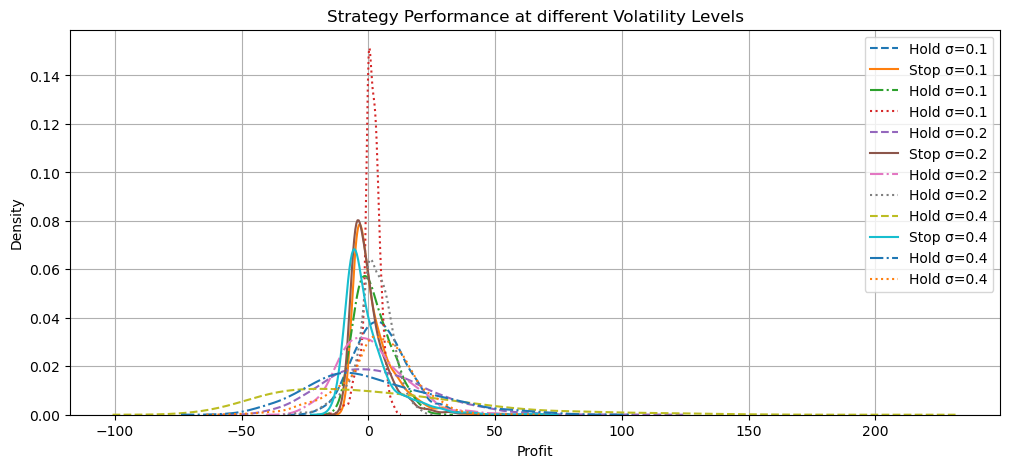

In [23]:
# Code for plotting the KDE comparison across the Volatilities

plt.figure(figsize =(12,5))
for sigma in vol_levels:
    sns.kdeplot(results[sigma]["hold"], label =f"Hold σ={sigma}", linestyle = '--')
    sns.kdeplot(results[sigma]["stop"], label =f"Stop σ={sigma}")
    sns.kdeplot(results[sigma]["ma"], label =f"Hold σ={sigma}", linestyle = '-.')
    sns.kdeplot(results[sigma]["boll"], label =f"Hold σ={sigma}", linestyle = 'dotted')
plt.title("Strategy Performance at different Volatility Levels")
plt.xlabel("Profit")
plt.ylabel("Density")
plt.grid(True)
plt.legend()
plt.show()


In [25]:
print("Volatility | Strategy       | Average Profit | Sharpe Ratio")
print("-----------|----------------|----------------|--------------")

for sigma in vol_levels:
    for strat in ["hold", "stop", "ma", "boll"]:
        profits = results[sigma][strat]
        avg = np.mean(profits)
        sr = sharpe_ratio(profits)
        print(f"{sigma:<10} | {strat:<14} | {avg:>14.2f} | {sr:>12.2f}")
    print("-----------|----------------|----------------|--------------")


Volatility | Strategy       | Average Profit | Sharpe Ratio
-----------|----------------|----------------|--------------
0.1        | hold           |           4.79 |         0.46
0.1        | stop           |           2.10 |         0.26
0.1        | ma             |           2.04 |         0.29
0.1        | boll           |           1.25 |         0.38
-----------|----------------|----------------|--------------
0.2        | hold           |           3.95 |         0.19
0.2        | stop           |           0.68 |         0.08
0.2        | ma             |           1.52 |         0.11
0.2        | boll           |           2.13 |         0.29
-----------|----------------|----------------|--------------
0.4        | hold           |           2.37 |         0.06
0.4        | stop           |           0.09 |         0.01
0.4        | ma             |           1.27 |         0.05
0.4        | boll           |           3.34 |         0.23
-----------|----------------|--------

## Conclusion

The Monte Carlo simulation allowed us to test trading strategies over 100+ possible futures. We observed that:

- Buy & Hold provides higher average returns in a steadily rising market.
- Trailing Stop can protect downside but may cut gains short.
- Trailing Stop is more stable in high volatility
- Moving Average gives higher profit but with more variability.
- Mean Reversion works best in sideways markets.


Such simulations are a core part of decision-making in quantitative finance, helping traders and researchers choose strategies with optimal expected performance under uncertainty.


# Summary

- We implemented four strategies and tested them using Monte Carlo price simulations.
- Trailing Stop Loss was risk-controlled, while MA Crossover had higher upside.
- Volatility has a major impact on strategy effectiveness.
- This project demonstrates strategy evaluation under randomness — a key concept in quant tradmentation
